A simple frequency-based pairing heap:

In [1]:
:ext BangPatterns

import Data.Semigroup     (Semigroup(..))
import Data.List.NonEmpty (NonEmpty(..))
import Data.Foldable      (Foldable(..))

data Heap a =
    Heap {-# UNPACK #-} !Int
         !a
         (HeapList a)

infixr 5 :-
data HeapList a
    = Nil
    | (:-) {-# UNPACK #-} !(Heap a)
           (HeapList a)

instance Foldable Heap where
    foldr f b (Heap _ x xs) = f x (foldr f b xs)

    foldl' f !b (Heap _ x xs) =
        case f b x of
            !b' -> foldl' f b' xs

instance Foldable HeapList where
    foldr _ b Nil                 = b
    foldr f b (Heap _ x xs :- ys) = f x (foldr f (foldr f b ys) xs)

    foldl' _ !b Nil = b
    foldl' f !b (Heap _ x xs :- ys) =
        case f b x of
            !b' -> case foldl' f b' xs of
              !b'' -> foldl' f b'' ys

instance Semigroup (Heap a) where
    (Heap i x xs) <> (Heap j y ys)
      | i <= j = Heap i x (Heap j y ys :- xs)
      | otherwise = Heap j y (Heap i x xs :- ys)
    sconcat (ys :| [])        = ys
    sconcat (ys :| [zs])      = ys <> zs
    sconcat (ys :| (z:zz:zs)) = (ys <> z) <> sconcat (zz :| zs)

mergeHeaps :: Heap a -> HeapList a -> Heap a
mergeHeaps t Nil               = t
mergeHeaps t1 (t2 :- Nil)      = t1 <> t2
mergeHeaps t1 (t2 :- t3 :- ts) = (t1 <> t2) <> mergeHeaps t3 ts

singleton :: Int -> a -> Heap a
singleton i x = Heap i x Nil

insert :: Int -> a -> Heap a -> Heap a
insert !i !x (Heap j y ys)
  | i <= j = Heap i x (Heap j y ys :- Nil)
  | otherwise = Heap j y (Heap i x Nil :- ys)

insertList :: Int -> a -> HeapList a -> Heap a
insertList !i !x Nil = Heap i x Nil
insertList !i !x (y :- ys) = insert i x (mergeHeaps y ys)

fromList :: [(Int,a)] -> Heap a
fromList [] = error "fromList: Empty list"
fromList (x:xs) = sconcat (fmap (uncurry singleton) (x :| xs))

minView :: Heap a -> (Int, a, Maybe (Heap a))
minView (Heap i x xs) = (i, x, case xs of
  Nil -> Nothing
  y :- ys -> Just (mergeHeaps y ys))

A function to count the frequencies of some elements:

In [2]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map

newtype Frequencies a
    = Frequencies
    { getFrequencies :: Map a Int
    }

frequencies :: (Ord a, Foldable f) => f a -> Frequencies a
frequencies = Frequencies . foldl' (\m x -> Map.insertWith (+) x 1 m) Map.empty

And a way to show frequencies

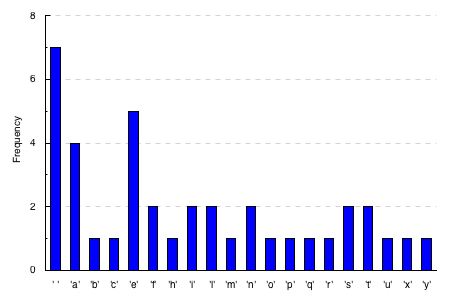

In [3]:
import Graphics.Rendering.Chart (layout_x_axis,laxis_generate,layout_y_axis
                                ,toRenderable,autoIndexAxis,laxis_title,layout_plots
                                ,plotBars,plot_bars_values,addIndexes)
import Data.Default.Class       (def)
import Control.Lens             ((.~))
import IHaskell.Display         (IHaskellDisplay(display))

instance Show a => IHaskellDisplay (Frequencies a) where
    display (Frequencies values)
        = display
        $ toRenderable
        $ layout_x_axis . laxis_generate .~ autoIndexAxis (map show (Map.keys values))
        $ layout_y_axis . laxis_title .~ "Frequency"
        $ layout_plots .~ [ plotBars
                          $ plot_bars_values .~ addIndexes (map pure (Map.elems values))
                          $ def ]
        $ def

:opt svg

frequencies "this is an example of a frequency table"

A Huffman tree:

In [4]:
:ext DeriveFoldable

import Data.Semigroup.Foldable (Foldable1(..))
import Data.Semigroup          (Semigroup(..))

data Tree a
    = Leaf {-# UNPACK #-} !Int a
    | Node {-# UNPACK #-} !Int (Tree a) (Tree a)
    deriving Foldable

instance Foldable1 Tree where
    foldMap1 f (Leaf _ x) = f x
    foldMap1 f (Node _ l r) = foldMap1 f l <> foldMap1 f r

And a way to display that

In [5]:
:ext FlexibleContexts

import           Diagrams.TwoD.Layout.Tree (renderTree,symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~))
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Tree

instance Show a => IHaskellDisplay (Tree a) where
    display = display . diagram . fblEx . toTree
      where
        toTree (Leaf i x) = Tree.Node (show i) [Tree.Node (show x) []]
        toTree (Node i l r) = Tree.Node (show i) [toTree l, toTree r]
        fblEx t' =
            renderTree 
                (\n -> text n # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white)
                (~~)
                (symmLayout t') # centerXY # pad 1.1

Building a tree is then easy:

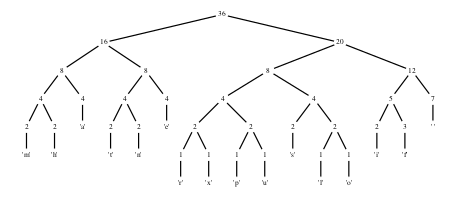

In [6]:
buildHuffman :: Heap (Tree a) -> Tree a
buildHuffman hp = case minView hp of
      (_,x,Nothing) -> x
      (i,x,Just xs) -> case minView xs of
        (j,y,Nothing) -> Node (i+j) x y
        (j,y,Just ys) -> buildHuffman (insert (i+j) (Node (i+j) x y) ys)

fromFrequencies :: Frequencies a -> Heap (Tree a)
fromFrequencies (Frequencies freqs) = 
    fromList [ (i, Leaf i v) | (v,i) <- Map.toList freqs ]

huffmanTree :: Ord a => [a] -> Tree a
huffmanTree = buildHuffman . fromFrequencies . frequencies

huffmanTree "this is an example of a huffman tree"

Some ranges:

In [19]:
import IHaskell.Display    (IHaskellDisplay(display),latex,Display)
import Data.Semigroup      (Semigroup(..))
import Control.Applicative (liftA2)

data Range a
    = Range
    { lowerBound :: Maybe a
    , upperBound :: Maybe a
    } deriving (Eq,Ord)
    
instance Show a => Show (Range a) where
    showsPrec _ (Range (Just l) (Just u)) = showChar '['
                                          . shows l
                                          . showChar ','
                                          . shows u
                                          . showChar ')'
    showsPrec _ (Range (Just l) Nothing) = shows l
                                         . showChar '≤'
    showsPrec _ (Range Nothing (Just u)) = showChar '<'
                                         . shows u
    showsPrec _ (Range Nothing Nothing) = showChar 'U'

instance (Show a, Ord a) => IHaskellDisplay (Range a) where
    display r = pure (Display [latex (lr r)])
      where
        lr (Range (Just l) (Just u)) = "$[" ++ show l ++ "," ++ show u ++ ")$"
        lr (Range (Just l) Nothing) = "$" ++ show l ++ "\\leq $"
        lr (Range Nothing (Just u)) = "$<" ++ show u ++ "$"
        lr (Range Nothing Nothing) = "$\\mathbb{U}$"

instance Ord a => Semigroup (Range a) where
    Range xl xu <> Range yl yu =
        Range
            (liftA2 min xl yl)
            (liftA2 max xu yu)
            
Range (Just 0) (Just 20) <> Range (Just 5) (Just 15)
Range (Just 0) Nothing   <> Range (Just 5) (Just 15)

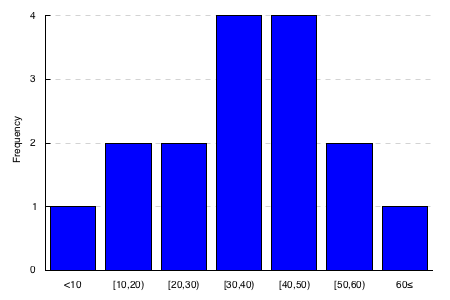

In [20]:
ages = Frequencies (Map.fromList
    [ (Range Nothing (Just 10)  , 1)
    , (Range (Just 10) (Just 20), 2)
    , (Range (Just 20) (Just 30), 2)
    , (Range (Just 30) (Just 40), 4)
    , (Range (Just 40) (Just 50), 4)
    , (Range (Just 50) (Just 60), 2)
    , (Range (Just 60) Nothing  , 1)
    ])

ages

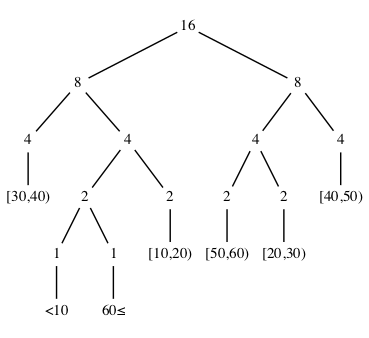

In [21]:
buildHuffman (fromFrequencies ages)

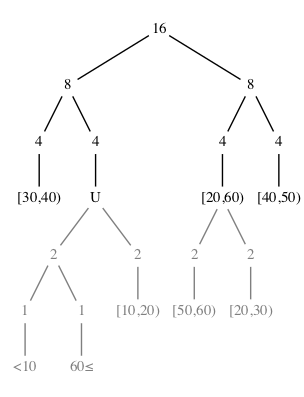

In [24]:
import           Diagrams.TwoD.Layout.Tree (renderTree',symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~),opacity,bg)
import           IHaskell.Display          (IHaskellDisplay(display)
                                           ,latex,Display(ManyDisplay))
import qualified Data.Tree                 as Tree
import           Data.Semigroup            (Semigroup(..))
import           Data.Semigroup.Foldable   (fold1)

data PrivateHuffman a
    = PrivateHuffman
    { kval :: Int
    , tree :: Tree a
    }

instance (Show a, Semigroup a) => IHaskellDisplay (PrivateHuffman a) where
    display (PrivateHuffman k tr) = 
        fmap (Display [ latex ("$k = " ++ show k ++ "$") ] <>)
                    ((display . diagram . bg white . fblEx . toTree False) tr)
      where
        size (Leaf i _) = i
        size (Node i _ _) = i
        toTree _ (Leaf i x) = Tree.Node (i < k, show i) [Tree.Node (i < k, show x) []]
        toTree False (Node i l r)
          | size l >= k && size r >= k =
               Tree.Node (i < k, show i) [toTree False l, toTree False r]
          | otherwise =
              Tree.Node (i < k, show i)
                  [ Tree.Node (i < k, show (fold1 l <> fold1 r))
                        [ toTree True l, toTree True r ] ]
        toTree True (Node i l r) = Tree.Node (True,show i) [toTree True l, toTree True r]
                        
        fblEx t' =
            renderTree'
                (\(b,n) -> text n # fontSizeL 0.2 # maybeOp b
                        <> circle 0.2 # fc white # lc white)
                (\((lb,_),ll) ((rb,_),rr) -> maybeOp (lb||rb) (ll ~~ rr))
                (symmLayout t') # centerXY # pad 1.1
        maybeOp False = id
        maybeOp True  = opacity 0.5

PrivateHuffman 4 (buildHuffman (fromFrequencies ages))